In [120]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [121]:
path = r'C:\Users\Eswar Nagu Pulipati\Downloads\lfw' 

In [122]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [123]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


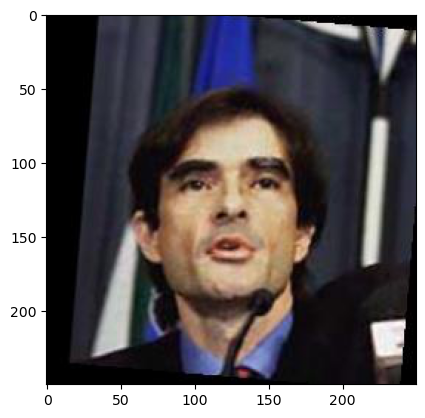

In [124]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

AutoEncoders (AEs) and Variational AutoEncoders (VAEs) differ significantly in their use, structure, and loss functions. AEs are mainly employed for reducing data dimensions and identifying key features, excelling in encoding data compactly for reconstruction and anomaly detection. Their straightforward design consists of an encoder for compressing data into a latent space and a decoder for reconstructing the original input.

On the other hand, VAEs are tailored for generative tasks, such as creating new data samples resembling the input, making them ideal for image generation and semi-supervised learning. VAEs differentiate themselves with an encoder that maps inputs to a distribution in the latent space, from which they sample to introduce variability. This leads to their ability to not only reconstruct but also generate novel data points.

The loss functions of these models also diverge. AEs typically use reconstruction loss like Mean Squared Error to measure fidelity, whereas VAEs combine this with the Kullback-Leibler divergence. This additional component in VAEs quantifies the difference between the learned latent distribution and a pre-defined one, usually a standard normal distribution, balancing reconstruction accuracy with the diversity of the generated data.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [125]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Adjusted Encoder Layers
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 30, kernel_size=5, stride=2, padding=2),  # Output: [30, 125, 125]
            nn.LeakyReLU(0.2),
            nn.Conv2d(30, 60, kernel_size=5, stride=2, padding=2), # Output: [60, 63, 63]
            nn.LeakyReLU(0.2),
            nn.Conv2d(60, 120, kernel_size=5, stride=2, padding=2),# Output: [120, 32, 32]
            nn.LeakyReLU(0.2),
            nn.Conv2d(120, 240, kernel_size=5, stride=2, padding=2)# Output: [240, 16, 16]
        )

        self.flatten_size = self.calculate_flatten_size((3, 250, 250))

        self.fc_mu = nn.Linear(self.flatten_size, 20)
        self.fc_logvar = nn.Linear(self.flatten_size, 20)

        # Adjusted Decoder
        self.decoder_fc = nn.Linear(20, self.flatten_size)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(240, 120, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(120, 60, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(60, 30, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(30, 3, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Sigmoid()
        )

    def calculate_flatten_size(self, input_shape):
        with torch.no_grad():
            dummy_data = torch.ones(1, *input_shape)
            x = self.encoder(dummy_data)
            return x.view(-1).shape[0]

    def encode(self, x):
        x = self.encoder(x).view(-1, self.flatten_size)
        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = F.relu(self.decoder_fc(z))
        z = z.view(-1, 240, 16, 16)
        z = self.decoder(z)
        # Resize the output to the desired dimensions
        z = F.interpolate(z, size=(250, 250), mode='bilinear', align_corners=False)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [126]:
# Initializing device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_vae_model = VAE().to(device)

data_iterator = iter(dataloader)
batch_images, _ = next(data_iterator)
batch_images = batch_images.to(device)

# Visualizing one of the images in the batch
def show_image(tensor_img, title=''):
    img = tensor_img.cpu().numpy().transpose(1, 2, 0)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

#show_image(batch_images[0], title='Original Image')

my_vae_model.eval()
with torch.no_grad():
    mu, logvar = my_vae_model.encode(batch_images[0].unsqueeze(0))
    latent_sample = my_vae_model.reparameterize(mu, logvar)

    # Decoding to generate an image
    regenerated_image = my_vae_model.decode(latent_sample)

    # Print shapes
    print("Shape of mu:", mu.shape)
    print("Shape of logvar:", logvar.shape)
    print("Shape of latent sample:", latent_sample.shape)
    print("Shape of regenerated image:", regenerated_image.shape)

    # Visualize the regenerated image
    #show_image(regenerated_image[0], title='Regenerated Image')

Shape of mu: torch.Size([1, 20])
Shape of logvar: torch.Size([1, 20])
Shape of latent sample: torch.Size([1, 20])
Shape of regenerated image: torch.Size([1, 3, 250, 250])


### Utilizing a VAE for Image Processing

1. **Instantiate VAE**: Create a VAE model and allocate it to a computational device (GPU/CPU).

2. **Load Image**: Fetch a batch of images using a DataLoader, selecting the first image and ensuring it's on the same device as the model.

3. **Encode Image**: Input the image into the VAE's encoder to get the latent space parameters: mean (mu) and log-variance (logvar).

4. **Generate Latent Sample**: Employ the reparameterization technique on mu and logvar to sample from the latent space.

5. **Decode Sample**: Pass the latent sample through the decoder to reconstruct or generate a new image.


This workflow demonstrates the core functionalities of a VAE, emphasizing the encoder's role in compressing data into a latent representation and the decoder's ability to reconstruct or synthesize new data from this latent space.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [127]:
total_model_params = sum(param.numel() for param in my_vae_model.parameters())
print(f"Total parameters in VAE model: {total_model_params}")

Total parameters in VAE model: 5643043


In [128]:
optimizer = torch.optim.Adam(my_vae_model.parameters(), lr=0.001)


In [129]:
def vae_combined_loss(output, original, latent_mean, latent_logvar):
    # Binary Cross Entropy Loss
    bce_loss = F.binary_cross_entropy(output, original, reduction='sum')

    # KL Divergence Loss
    kl_div_loss = -0.5 * torch.sum(1 + latent_logvar - latent_mean.pow(2) - latent_logvar.exp())

    # Total Loss
    total_loss = bce_loss + kl_div_loss
    return total_loss

The loss function in a Variational Autoencoder (VAE) comprises two main components:

1. **Reconstruction Loss**: Measures the difference between the original input and the reconstructed output. It ensures the VAE can accurately reconstruct data from the latent space. For continuous data, Mean Squared Error (MSE) is typically used.

2. **Kullback-Leibler (KL) Divergence**: Acts as a regularizer. It compares the distribution of the encoded latent variables with a standard normal distribution, encouraging the latent space to have a regular structure. This promotes better generation of new, coherent data.

The total loss is the sum of these two components. While the reconstruction loss ensures accurate data reconstruction, the KL divergence ensures a well-structured and meaningful latent space. This dual-objective loss function is essential for the VAE's ability to both reconstruct and generate data effectively.

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [130]:
# Setting the number of training epochs
total_epochs = 10

# Training loop
for epoch in range(total_epochs):
    my_vae_model.train()  # Switching model to training mode
    total_loss = 0

    # Iterating over each batch in the dataloader
    for batch_num, (img_batch, _) in enumerate(dataloader):
        img_batch = img_batch.to(device)
        optimizer.zero_grad()
        output, lat_mean, lat_logvar = my_vae_model(img_batch)
        current_loss = vae_combined_loss(output, img_batch, lat_mean, lat_logvar)
        current_loss.backward()
        total_loss += current_loss.item()
        optimizer.step()

        if batch_num % 10 == 0:
            print(f"Epoch {epoch+1} / {total_epochs} - Batch {batch_num}, Current Loss: {current_loss.item() / len(img_batch):.4f}")

    # Calculating and displaying average loss after each epoch
    mean_loss = total_loss / len(dataloader.dataset)
    print(f"==> End of Epoch {epoch+1}, Mean Loss: {mean_loss:.4f}")

# Sampling and visualization of generated images
with torch.no_grad():
    my_vae_model.eval()  # Switching model to evaluation mode
    random_vectors = torch.randn(64, 20).to(device)
    generated_imgs = my_vae_model.decode(random_vectors).cpu()


Epoch 1 / 10 - Batch 0, Current Loss: 129199.9844
Epoch 1 / 10 - Batch 10, Current Loss: 127141.0859
Epoch 1 / 10 - Batch 20, Current Loss: 133426.8594
Epoch 1 / 10 - Batch 30, Current Loss: 131156.8438
Epoch 1 / 10 - Batch 40, Current Loss: 129095.4453
Epoch 1 / 10 - Batch 50, Current Loss: 124243.8281
Epoch 1 / 10 - Batch 60, Current Loss: 122395.5312
Epoch 1 / 10 - Batch 70, Current Loss: 119813.4531
Epoch 1 / 10 - Batch 80, Current Loss: 115616.3438
Epoch 1 / 10 - Batch 90, Current Loss: 112494.0781
Epoch 1 / 10 - Batch 100, Current Loss: 121644.4922
Epoch 1 / 10 - Batch 110, Current Loss: 119268.6719
Epoch 1 / 10 - Batch 120, Current Loss: 119497.6719
Epoch 1 / 10 - Batch 130, Current Loss: 123236.6094
Epoch 1 / 10 - Batch 140, Current Loss: 119678.3359
Epoch 1 / 10 - Batch 150, Current Loss: 115501.9531
Epoch 1 / 10 - Batch 160, Current Loss: 112140.1484
Epoch 1 / 10 - Batch 170, Current Loss: 112271.4688
Epoch 1 / 10 - Batch 180, Current Loss: 113617.0234
Epoch 1 / 10 - Batch 19

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

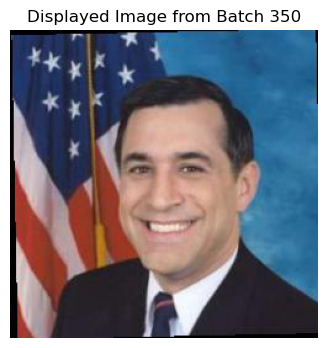

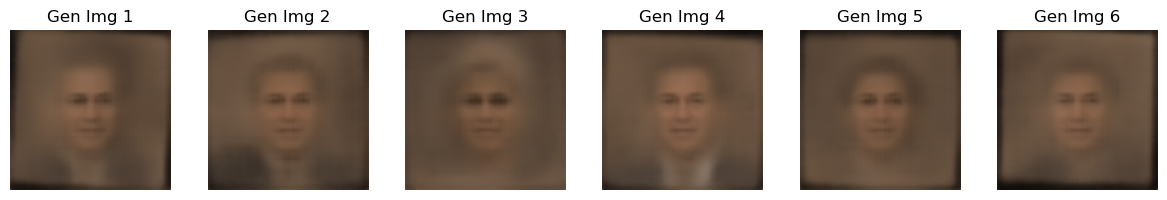

In [131]:
import matplotlib.pyplot as plt
import random

# Evaluating the VAE model
my_vae_model.eval()

# Displaying a randomly chosen original image from the dataloader
with torch.no_grad():
    chosen_index = random.randint(0, len(dataloader) - 1)
    for idx, (batch_data, _) in enumerate(dataloader):
        if idx == chosen_index:
            selected_image = batch_data[0].to(device)
            plt.figure(figsize=(4, 4))
            plt.imshow(selected_image.cpu().permute(1, 2, 0))
            plt.title(f"Displayed Image from Batch {chosen_index}")
            plt.axis('off')
            plt.show()
            break

# Generating and displaying images using the VAE model
with torch.no_grad():
    random_vectors = torch.randn(6, 20).to(device)  # Generating 6 random vectors
    gen_images = my_vae_model.decode(random_vectors).cpu()

    # Setting up a grid for visualization
    fig, ax = plt.subplots(1, 6, figsize=(12, 2))
    for i, img in enumerate(gen_images):
        ax[i].imshow(img.permute(1, 2, 0))
        ax[i].set_title(f"Gen Img {i+1}")
        ax[i].axis('off')
    plt.tight_layout()
    plt.show()
